<a href="https://colab.research.google.com/github/eluyutao/goemotion/blob/main/oversample_DistilBertForSequenc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MMAI 894 - SENTIMENT ANALYSIS based on Exercise 3
## Transfer learning with DistilBert
The goal of this excercise is to build a text classifier using the pretrained DistilBert published by HuggingFace. You will be doing this using the Glue/CoLA dataset (https://nyu-mll.github.io/CoLA/).



In [ ]:
# This cell installs and sets up DistilBert import, as well as the dataset, which we will 
# use tf.datasets to load (https://www.tensorflow.org/datasets/catalog/overview)

!pip install -q transformers tfds-nightly
!pip install keras_tuner
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import pandas as pd

try: # this is only working on the 2nd try in colab :)
  from transformers import DistilBertTokenizer, TFDistilBertModel, TFDistilBertForSequenceClassification, DistilBertConfig
except Exception as err: # so we catch the error and import it again
  from transformers import DistilBertTokenizer, TFDistilBertModel, TFDistilBertForSequenceClassification, DistilBertConfig

import numpy as np
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Input, Dropout

import tensorflow_datasets as tfds

dbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# My additions
!pip install tensorflow-addons
import tensorflow as tf
import tensorflow_addons as tfa
from keras import backend as K
#from transformers import DefaultDataCollator

In [ ]:
# From Lucas, needed for preprocessing
!pip install emot

import pandas as pd
import emot, re
from sklearn.model_selection import train_test_split
from emot.emo_unicode import UNICODE_EMOJI, EMOTICONS_EMO
pd.set_option("display.max_columns", 99)

     |████████████████████████████████| 61 kB 27 kB/s 


# Get the GOEMOTIONS Datasets

In [ ]:
! wget data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv
! wget data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_2.csv
! wget data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_3.csv
goemotions_1 = pd.read_csv('goemotions_1.csv')
goemotions_2 = pd.read_csv('goemotions_2.csv')
goemotions_3 = pd.read_csv('goemotions_3.csv')
frames = [goemotions_1, goemotions_2, goemotions_3]
df = pd.concat(frames, ignore_index=True)

--2022-03-27 16:12:54--  http://data/full_dataset/
Resolving data (data)... failed: No address associated with hostname.
wget: unable to resolve host address ‘data’
--2022-03-27 16:12:54--  https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 74.125.24.128, 142.251.10.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14174600 (14M) [application/octet-stream]
Saving to: ‘goemotions_1.csv’

goemotions_1.csv    100%[===================>]  13.52M  29.1MB/s    in 0.5s    

2022-03-27 16:12:56 (29.1 MB/s) - ‘goemotions_1.csv’ saved [14174600/14174600]

FINISHED --2022-03-27 16:12:56--
Total wall clock time: 1.4s
Downloaded: 1 files, 14M in 0.5s (29.1 MB/s)
--2022-03-27 16:12:56--  http://data/full_dataset/
Resolving data (data)... failed: No address associated with hostname.
w

In [ ]:
print(df.shape)
df.head(2)

(211225, 37)


,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,disappointment,disapproval,disgust,embarrassment,excitement,fear,gratitude,grief,joy,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,That game hurt.,eew5j0j,Brdd9,nrl,t3_ajis4z,t1_eew18eq,1.548381e+09,1,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,>sexuality shouldn’t be a grouping category I...,eemcysk,TheGreen888,unpopularopinion,t3_ai4q37,t3_ai4q37,1.548084e+09,37,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Start Data Preparation

In [ ]:
%%time
# emotion label columns
lb_col = df.columns[9:]
print(f'Entire dataset: {df.shape}')
# remove examples that were very unclear. They do not have any emotions labels
df2 = df[~df['example_very_unclear']].copy()
print(f'{df2.shape[0]} rows left after removing records with unclear emotions')
# Sum the emotions together because there are different raters
df2 = df2[['text']+list(lb_col)].groupby(['text']).sum().reset_index()
print(f'{df2.shape[0]} rows left after deduping on text and id columns')
# keep records where there are at least two agreeing emotion labels
df2['at_least_2_agree'] = df2[lb_col].apply(lambda x: x.max(), axis=1)
df2 = df2[df2.at_least_2_agree >= 2]
#df2 = df2.replace({1: 0, 2: 1, 3: 1, 4: 1, 5: 1}, inplace=False)
#df_clean = df2.drop('at_least_2_agree', axis=1)
#print(f'{df2.shape[0]} rows left after removing records without having at least two raters agreeing on the emotion')
#df2 = df2[df2.at_least_2_agree >= 2]
print(df2.at_least_2_agree.unique())

Entire dataset: (211225, 37)
207814 rows left after removing records with unclear emotions
57730 rows left after deduping on text and id columns
[ 2  3  4  5  7  6 12 13 14  8 17  9 10 15 33 11 45 22]
CPU times: user 2.44 s, sys: 491 ms, total: 2.93 s
Wall time: 2.43 s


In [ ]:
for col in df2.columns[1:]:
    df2[col] = df2[col].apply(lambda x: 0 if x <= 1 else 1)

# df2 = df2.replace({1: 0, 2: 1, 3: 1, 4: 1, 5: 1}, inplace=False)
df_clean = df2.drop('at_least_2_agree', axis=1)
print(f'{df2.shape[0]} rows left after removing records without having at least two raters agreeing on the emotion')

print(df_clean.shape)
df_clean.head(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


53994 rows left after removing records without having at least two raters agreeing on the emotion
(53994, 29)


,text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,disappointment,disapproval,disgust,embarrassment,excitement,fear,gratitude,grief,joy,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,"""If you don't wear BROWN AND ORANGE...YOU DON...",0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,"""What do Scottish people look like?"" How I wo...",0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [ ]:
def convert_emojis(text):
    for emot in UNICODE_EMOJI:
        if emot in text:
            orig = text
            text = text.replace(emot, "_".join(UNICODE_EMOJI[emot].replace(",","").replace(":","").split()))
            #print(f'{orig} -> {text}', '\n')
    return text

def convert_emoticons(text):
    for emot in EMOTICONS_EMO:
        if emot in text:
            orig = text
            text = text.replace(emot, "_".join(EMOTICONS_EMO[emot].split()))
            #print(f'{orig} -> {text}', '\n')
    return text

In [ ]:
%%time
print('-------replacing emoji with text---------')
df_clean['text'] = df_clean['text'].apply(lambda x: convert_emojis(x))
print('-------replacing emoticon with text---------')
df_clean['text'] = df_clean['text'].apply(lambda x: convert_emoticons(x))

-------replacing emoji with text---------
-------replacing emoticon with text---------
CPU times: user 7.25 s, sys: 0 ns, total: 7.25 s
Wall time: 7.23 s


In [ ]:
# Based on experimentation, the emotions which are classified best have at
# least 2500 instances in the dataset.  

# The following classes are HEAVILY underrepresented in the data:
#   Emotion        Count
#   --------------------
#   grief          97
#   pride          142
#   relief         182
#   nervousness    208
#   embarrassment	 374

# df_clean.drop(columns=['grief', 'pride', 'relief', 'nervousness', 'embarrassment'], inplace=True)
labels_to_drop = ['grief', 'pride', 'relief', 'nervousness', 'embarrassment']
for col in df_clean.columns[1:]:
  if col in labels_to_drop:
    df_clean[col] = 0
df_clean['sum_label'] = df_clean[1:].sum(axis=1)
df_clean = df_clean[df_clean.sum_label > 0]
df_clean.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


(53425, 30)

In [ ]:
df_clean.drop(labels=labels_to_drop+['sum_label'], inplace=True, axis=1)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print(df_clean.shape)
X = df_clean['text']
y = df_clean.iloc[:,1:]
y.head(2)

(53425, 24)


,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,disappointment,disapproval,disgust,excitement,fear,gratitude,joy,love,optimism,realization,remorse,sadness,surprise,neutral
1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)
print(y_train.shape)

(48082, 23)


In [ ]:
train_data = pd.merge(X_train, y_train, how='inner', left_index=True, right_index=True)
train_data.shape

(48082, 24)

In [ ]:
# # => Brute force oversample these until ~2500 instances
def gross_up_class(df, class_name):
    orig_shape = df[class_name].sum()
    print(f"{class_name} originally have {orig_shape} 1's")
    if orig_shape < 2500:
      # df_temp = pd.DataFrame()
      n = 2500 - df[df[class_name] == 1].shape[0]
      print(f'need to oversample {n} instances')
      replace = True if n > orig_shape else False
      smpl = df[df[class_name] == 1].sample(n, replace = replace)
      df = pd.concat([df, smpl], ignore_index=True)
      print(class_name, df[class_name].sum(), '\n')
    else:
      print("no need to oversample current class'\n'")
    return df

for col in y_train.columns:
  train_data = gross_up_class(train_data, col)


admiration originally have 4617 1's
no need to oversample current class'
'
amusement originally have 2577 1's
no need to oversample current class'
'
anger originally have 1753 1's
need to oversample 747 instances
anger 2500 

annoyance originally have 2931 1's
no need to oversample current class'
'
approval originally have 3333 1's
no need to oversample current class'
'
caring originally have 1223 1's
need to oversample 1277 instances
caring 2500 

confusion originally have 1504 1's
need to oversample 996 instances
confusion 2500 

curiosity originally have 2652 1's
no need to oversample current class'
'
desire originally have 740 1's
need to oversample 1760 instances
desire 2500 

disappointment originally have 1495 1's
need to oversample 1005 instances
disappointment 2500 

disapproval originally have 2430 1's
need to oversample 70 instances
disapproval 2500 

disgust originally have 977 1's
need to oversample 1523 instances
disgust 2500 

excitement originally have 1012 1's
need to 

In [ ]:
# # The following class is HEAVILY overrepresented in the data:
# #   Emotion        Count
# #   --------------------
# #   neutral	       17742
# #
# # => Want to drop ~10k instances, but only those purely labeled as neutral

keep_neutral_sample = 7000
train_data['num_senti'] = train_data.iloc[:,1:].sum(axis=1)
train_data.loc[(train_data['num_senti'] == 1) & (train_data['neutral'] == 1), 'only_neutral'] = 1
print(f'only neutral: {train_data[train_data.only_neutral==1].shape}')
neutral_sample = train_data[train_data.only_neutral==1].sample(keep_neutral_sample)
train_data_no_only_neutral = train_data[train_data.only_neutral != 1].copy()
train_data = pd.concat([train_data_no_only_neutral, neutral_sample], ignore_index=True)
print(train_data.shape)
print([f'{col}: {train_data[col].sum()}' for col in y_train.columns])

only neutral: (14370, 26)
(56958, 26)
['admiration: 5221', 'amusement: 2813', 'anger: 2788', 'annoyance: 3359', 'approval: 3752', 'caring: 2861', 'confusion: 2674', 'curiosity: 2970', 'desire: 2755', 'disappointment: 2851', 'disapproval: 2617', 'disgust: 2675', 'excitement: 2754', 'fear: 2601', 'gratitude: 3281', 'joy: 2580', 'love: 2627', 'optimism: 2612', 'realization: 2599', 'remorse: 2582', 'sadness: 2509', 'surprise: 2500', 'neutral: 9193']


In [ ]:
train_data.head(2)

,text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,disappointment,disapproval,disgust,excitement,fear,gratitude,joy,love,optimism,realization,remorse,sadness,surprise,neutral,num_senti,only_neutral
0,I stopped watching after I had to suffer throu...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,NaN
1,"Struggling to get the basics with a $1,000 pho...",0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,NaN


In [ ]:
train_data.drop(labels=['num_senti','only_neutral'], inplace=True, axis=1)
train_data.shape

(56958, 24)

In [ ]:
X_train = train_data.text
y_train = train_data.iloc[:, 1:]

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=2)
print(f'X_train shape: {X_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_val shape: {y_val.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (49838,)
X_val shape: (7120,)
X_test shape: (5343,)
y_train shape: (49838, 23)
y_val shape: (7120, 23)
y_test shape: (5343, 23)


In [ ]:
# # XXX Come back later and go from Series to list. Skip the dataframe step
df_X_train = X_train.to_frame()
df_X_val   = X_val.to_frame()
df_X_test  = X_test.to_frame()

Next, we need to prepare the text for DistilBert. Instead of ingesting raw text, the model uses token IDs to map to internal embedding. Additionally, since the input is fixed size (due to our use of batches), we need to let the model know which tokens to use (i.e. are part of the sentence).

Luckily, `dbert_tokenizer` takes care of all that for us - 
- Preprocessing: https://huggingface.co/transformers/preprocessing.html
- Summary of tokenizers (DistilBert uses WordPiece): https://huggingface.co/transformers/tokenizer_summary.html#wordpiece

In [ ]:
def calculating_class_weights(Y_train):
    from sklearn.utils.class_weight import compute_class_weight
    number_dim = np.shape(Y_train)[1]
    weights = np.empty([number_dim, 2])
    for i in range(number_dim):
        weights[i] = compute_class_weight(class_weight = 'balanced', 
                                          classes = np.unique(Y_train.iloc[:, i]), 
                                          y = Y_train.iloc[:, i])
    return weights
def get_weighted_loss(weights):
    def weighted_loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        return K.mean((weights[:,0]**(1-y_true))*(weights[:,1]**(y_true))*K.binary_crossentropy(y_true, y_pred), axis=-1)
    return weighted_loss

In [ ]:
class_weights = calculating_class_weights(y_train)

In [ ]:
def make_y_a_numpy_array(df):
  # Initially thoughts I needed lists, but this is simple df to numpy
  y = df.to_numpy()
  return y


def encode_text(text):
    # TODO: encode text using dbert_tokenizer
    # DO NOT CHANGE THE INPUTS OR OUTPUTS TO THIS FUNCTION

    batch_size = 128
    input_ids = []
    attention_mask = []

    temp = text['text'].to_list()
    for count in range(0, len(text), batch_size):
      batch_text = temp[count:count+batch_size]
      # have to truncate b/c was resulting in a non-rectangular shape
      output = dbert_tokenizer(batch_text,
                             padding='max_length',
                             return_attention_mask=True,
                             max_length=256, #96  # was 512, but took waay too long
                             truncation=True
                             )
      input_ids.extend(output['input_ids'])
      attention_mask.extend(output['attention_mask'])

    # Try switching everything to numpy arrays
    input_ids = np.array(input_ids)
    attention_mask = np.array(attention_mask)

    return input_ids, attention_mask

# the following prepares the input for running in DistilBert
np_array_y_train = make_y_a_numpy_array(y_train)
np_array_y_val   = make_y_a_numpy_array(y_val)
np_array_y_test  = make_y_a_numpy_array(y_test)

train_input, train_mask = encode_text(df_X_train)
val_input, val_mask = encode_text(df_X_val)
test_input, test_mask = encode_text(df_X_test)

train_model_inputs_and_masks = {
    'inputs' : train_input,
    'masks' : train_mask
}

val_model_inputs_and_masks = {
    'inputs' : val_input,
    'masks' : val_mask
}

test_model_inputs_and_masks = {
    'inputs' : test_input,
    'masks' : test_mask
}

# Modelling

## Build and Train Model

Resources:
- BERT paper https://arxiv.org/pdf/1810.04805.pdf
- DistilBert paper: https://arxiv.org/abs/1910.01108
- DistilBert Tensorflow Documentation: https://huggingface.co/transformers/model_doc/distilbert.html#tfdistilbertmodel

In [ ]:
def build_model(base_model, trainable=False, params={}):
    # TODO: build the model, with the option to freeze the parameters in distilBERT
    # DO NOT CHANGE THE INPUTS OR OUTPUTS TO THIS FUNCTION
    # Hint 1: the cls token (token for classification in bert / distilBert) corresponds to the first element in the sequence in DistilBert. Take a look at Figure 2 in BERT paper.
    # Hint 2: this guide may be helpful for parameter freezing: https://keras.io/guides/transfer_learning/
    # Hint 3: double check that your number of parameters make sense
    # Hint 4: carefully consider your final layer activation and loss function

    # Refer to https://keras.io/api/layers/core_layers/input/
    max_seq_len = params['max_seq_len']
    layer_dropout = params['layer_dropout']
    random_seed = params['random_seed']

    initial_weights = keras.initializers.GlorotNormal(seed=random_seed)

    inputs = Input(shape=(max_seq_len,), 
                   name='input_ids', 
                   dtype='int32')
    masks  = Input(shape=(max_seq_len,), 
                   name='input_attention', 
                   dtype='int32')

    base_model.trainable = trainable
    # Added for TFDistilBertForSequenceClassification
    bert = base_model.layers[0]
    dbert_output = bert(inputs, attention_mask=masks)
    
    # Uncomment below for bare DistilBERT
    # dbert_output = base_model(inputs, attention_mask=masks)

    # dbert_last_hidden_state gets you the output encoding for each of your tokens.
    # Each such encoding is a vector with 768 values. The first token fed into the model is [cls]
    # which can be used to build a sentence classification network
    dbert_last_hidden_state = dbert_output.last_hidden_state


    # Any additional layers should go here
    # use the 'params' as a dictionary for hyper parameter to facilitate experimentation
    cls_token = dbert_last_hidden_state[:, 0, :]
    X = tf.keras.layers.BatchNormalization()(cls_token)
    X = tf.keras.layers.Dense(192, activation='relu')(X)
    X = tf.keras.layers.Dropout(layer_dropout)(X)

    my_output = X
    probs = Dense(23, #28, 
                  #activation='softmax',
                  activation='sigmoid',
                  kernel_initializer=initial_weights,  
                  kernel_constraint=None,
                  bias_initializer='zeros'
                  )(my_output)

    model = keras.Model(inputs=[inputs, masks], outputs=probs)
    model.summary()
    return model

# dbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')
dbert_model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', output_hidden_states=False)
params= {
        "max_seq_len":256,
        "layer_dropout":0.25,
        "learning":4e-4,
        "random_seed":91
        }

model = build_model(dbert_model, params=params)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_transform', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_99', 'pre_classifier', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 input_attention (InputLayer)   [(None, 256)]        0           []                               
                                                                                                  
 distilbert (TFDistilBertMainLa  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 yer)                           ast_hidden_state=(N               'input_attention[0][0]']        
                                one, 256, 768),                                                   
                                 hidden_states=None                                           

In [ ]:
def compile_model(model):
    # TODO: compile the model, include relevant auc metrics when training
    # DO NOT CHANGE THE INPUTS OR OUTPUTS TO THIS FUNCTION

    # Metrics
    #     "Hamming loss is the fraction of wrong labels to the total number of labels.
    #      In multi-class classification, hamming loss is calculated as the hamming 
    #      distance between y_true and y_pred. In multi-label classification, hamming
    #      loss penalizes only the individual labels.""
    metrics = [tfa.metrics.HammingLoss(mode='multiclass', name='hamming-mc', dtype=tf.float32, threshold=0.2),
               tfa.metrics.HammingLoss(mode='multilabel', name='hamming-ml', dtype=tf.float32, threshold=0.4),
               keras.metrics.CategoricalCrossentropy('Cat-CE', dtype=tf.float32),
               keras.metrics.BinaryCrossentropy('Bin-CE', dtype=tf.float32, label_smoothing=0.5),
               keras.metrics.CategoricalAccuracy()]

    # Loss
    #loss = keras.losses.SparseCategoricalCrossentropy()
    
    # Switch to Categorical to support multi-class classification
    #    loss = keras.losses.CategoricalCrossentropy()
    # Try binary cross-entropy and switch model to sigmoid
    #    loss = keras.losses.BinaryCrossentropy()
    # Use a new one from TFA

    loss = tfa.losses.SigmoidFocalCrossEntropy()
    # loss = get_weighted_loss(class_weights)

    model.compile(keras.optimizers.Adam(learning_rate=params['learning']), 
                  loss=loss,
                  metrics=metrics)

    return model

model = compile_model(model)

In [ ]:
def train_model(model, model_inputs_and_masks_train, model_inputs_and_masks_val,
    y_train, y_val, batch_size, num_epochs):
    # TODO: train the model
    # DO NOT CHANGE THE INPUTS OR OUTPUTS TO THIS FUNCTION
    #class_weights = calculating_class_weights(y_train)

    history = model.fit(x = [model_inputs_and_masks_train["inputs"], 
                        train_model_inputs_and_masks["masks"]],
                        y = y_train,
                        batch_size=batch_size, epochs=num_epochs, 
                        validation_data=([model_inputs_and_masks_val["inputs"],
                                          model_inputs_and_masks_val["masks"]],
                                         y_val),
                        verbose=2)
    #,
                        #class_weight=class_weights)

    return model, history

model, history = train_model(model, train_model_inputs_and_masks, val_model_inputs_and_masks, np_array_y_train, np_array_y_val, batch_size=32, num_epochs=3)

In [ ]:
def train_model(model, model_inputs_and_masks_train, model_inputs_and_masks_val,
    y_train, y_val, batch_size, num_epochs):
    # TODO: train the model
    # DO NOT CHANGE THE INPUTS OR OUTPUTS TO THIS FUNCTION
    #class_weights = calculating_class_weights(y_train)

    history = model.fit(x = [model_inputs_and_masks_train["inputs"], 
                        train_model_inputs_and_masks["masks"]],
                        y = y_train,
                        batch_size=batch_size, epochs=num_epochs, 
                        validation_data=([model_inputs_and_masks_val["inputs"],
                                          model_inputs_and_masks_val["masks"]],
                                         y_val),
                        verbose=2)#,
                        #class_weight=class_weights)

    return model, history

model, history = train_model(model, train_model_inputs_and_masks, val_model_inputs_and_masks, np_array_y_train, np_array_y_val, batch_size=32, num_epochs=3)

Epoch 1/3
1558/1558 - 549s - loss: 0.5861 - hamming-mc: 0.2941 - hamming-ml: 0.0776 - Cat-CE: 3.5029 - Bin-CE: 0.7372 - categorical_accuracy: 0.2138 - val_loss: 0.3386 - val_hamming-mc: -7.0225e-03 - val_hamming-ml: 0.0510 - val_Cat-CE: 2.9702 - val_Bin-CE: 0.6836 - val_categorical_accuracy: 0.3728 - 549s/epoch - 352ms/step
Epoch 2/3
1558/1558 - 543s - loss: 0.3775 - hamming-mc: 0.0952 - hamming-ml: 0.0547 - Cat-CE: 3.0879 - Bin-CE: 0.7097 - categorical_accuracy: 0.3225 - val_loss: 0.3155 - val_hamming-mc: -6.7837e-02 - val_hamming-ml: 0.0488 - val_Cat-CE: 2.8639 - val_Bin-CE: 0.6899 - val_categorical_accuracy: 0.4174 - 543s/epoch - 349ms/step
Epoch 3/3
1558/1558 - 542s - loss: 0.3487 - hamming-mc: 0.0289 - hamming-ml: 0.0517 - Cat-CE: 2.9862 - Bin-CE: 0.7110 - categorical_accuracy: 0.3592 - val_loss: 0.3067 - val_hamming-mc: -9.9298e-02 - val_hamming-ml: 0.0476 - val_Cat-CE: 2.8146 - val_Bin-CE: 0.6955 - val_categorical_accuracy: 0.4226 - 542s/epoch - 348ms/step


In [ ]:
test_df = pd.DataFrame()
labels = []
predicts = []
iteration = []

def eval_model(model, inputs_and_masks, label):

    test_scores = model.evaluate(x = [inputs_and_masks["inputs"], 
                        inputs_and_masks["masks"]],
                        y = label, verbose=2)
    test_loss = test_scores[0]
    test_metrics = test_scores[1]
    print("Test loss:", test_loss)
    print("Test accuracy:", test_metrics)
    
    # collect the first 30 predictions looking for incorrect ones
    predictions = model.predict([inputs_and_masks["inputs"], 
                        inputs_and_masks["masks"]])
    for i in range(len(predictions)):
      labels.append(label[i])
      predicts.append(predictions[i])
      iteration.append(i)

      #print(i, ":\t", label[i].argmax(), "\n\t", predictions[i].argmax())
    test_df['Labels'] = labels
    test_df['Predictions'] = predicts
    test_df['Iteration'] = iteration
    return test_loss, test_metrics

test_loss, test_metrics = eval_model(model, test_model_inputs_and_masks, np_array_y_test)

167/167 - 47s - loss: 0.2975 - hamming-mc: 0.0032 - hamming-ml: 0.0463 - Cat-CE: 2.5927 - Bin-CE: 0.6952 - categorical_accuracy: 0.4385 - 47s/epoch - 281ms/step
Test loss: 0.2975368797779083
Test accuracy: 0.003181733191013336


In [ ]:
rounded_pred = []

test_df['Rounded_Pred'] = test_df['Predictions'].copy()

for i in range(test_df.shape[0]):
  arr = test_df['Rounded_Pred'][i]
  arr[arr <= 0.2] = 0
  arr[arr > 0.2] = 1
  rounded_pred.append(arr)

test_df['Rounded_Pred'] = rounded_pred
test_df.head()

,Labels,Predictions,Iteration,Rounded_Pred
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, ...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, ..."
1,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, ...",1,"[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, ..."
2,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, ...",2,"[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, ..."
3,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3,"[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",4,"[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."


## Custom Multi-label Accuracy metric

Thiebaut N. Multi-label classification with BERT. Data4thought: data science blog. Published January 29, 2021. Accessed March 25, 2022. https://data4thought.com/toxic_comments_transformer.html

In [ ]:
def multi_label_accuracy(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
    """For multi-label classification, one has to define a custom
    acccuracy function because neither tf.keras.metrics.Accuracy nor
    tf.keras.metrics.CategoricalAccuracy evaluate the number of 
    exact matches.

    :Example:
    >>> from tensorflow.keras import metrics
    >>> y_true = tf.convert_to_tensor([[1., 1.]])
    >>> y_pred = tf.convert_to_tensor([[1., 0.]])
    >>> metrics.Accuracy()(y_true, y_pred).numpy()
    0.5
    >>> metrics.CategoricalAccuracy()(y_true, y_pred).numpy()
    1.0
    >>> multi_label_accuracy(y_true, y_pred).numpy()
    0.0
    """   
    y_pred = tf.math.round(y_pred)
    exact_matches = tf.math.reduce_all(y_pred == y_true, axis=1)
    exact_matches = tf.cast(exact_matches, tf.float32)
    return tf.math.reduce_mean(exact_matches)

In [ ]:
metric2 = tfa.metrics.HammingLoss(mode='multiclass', threshold=0.2)

y_true = tf.convert_to_tensor(labels, dtype=tf.float32)
y_pred = tf.convert_to_tensor(predicts, dtype=tf.float32)

metric2.update_state(y_true, y_pred)
print("Hamming distance: ", metric2.result().numpy())

metric3 = tf.keras.metrics.KLDivergence()
metric3.update_state(y_true, y_pred)
print("\nKL Divergence: ", metric3.result().numpy())

metric4 = tf.keras.metrics.Accuracy()
metric4.update_state(y_true, y_pred)
print("\nAccuracy: ", metric4.result().numpy())

metric6 = tfa.metrics.F1Score(num_classes=23, threshold=0.5) # was 28 classes
metric6.update_state(y_true, y_pred)
print("\nF1 Score: ", metric6.result().numpy())

metric7 = tf.keras.metrics.SensitivityAtSpecificity(0.85)
metric7.update_state(y_true, y_pred)
print("\nSensitivity: ", metric7.result().numpy())

metric8 = multi_label_accuracy(y_true, y_pred)
#assert metric8.shape == (2,)
print("\nMulti-label Accuracy: ", metric8)

metric5 = tfa.metrics.MultiLabelConfusionMatrix(num_classes=23) # was 28 classes
metric5.update_state(y_true, y_pred)
print("\nMulti-label Confusion Matrices: \n", metric5.result().numpy())

Hamming distance:  0.0031817332

KL Divergence:  2.8296344

Accuracy:  0.8084857

F1 Score:  [0.40751174 0.42598686 0.27279812 0.22150436 0.22066277 0.22321428
 0.22807017 0.39685315 0.14468084 0.12765956 0.24131146 0.12380952
 0.12466124 0.17489421 0.57630336 0.23173803 0.42443064 0.2791971
 0.10193051 0.20700637 0.24591574 0.1598063  0.5907534 ]

Sensitivity:  0.0

Multi-label Accuracy:  tf.Tensor(0.020962005, shape=(), dtype=float32)

Multi-label Confusion Matrices: 
 [[[3647. 1201.]
  [  61.  434.]]

 [[4386.  642.]
  [  56.  259.]]

 [[4235.  903.]
  [  30.  175.]]

 [[3416. 1616.]
  [  71.  240.]]

 [[3061. 1921.]
  [  78.  283.]]

 [[4348.  844.]
  [  26.  125.]]

 [[4232.  934.]
  [  34.  143.]]

 [[4426.  670.]
  [  20.  227.]]

 [[4689.  578.]
  [  25.   51.]]

 [[3715. 1475.]
  [  42.  111.]]

 [[4002. 1096.]
  [  61.  184.]]

 [[4358.  890.]
  [  30.   65.]]

 [[4305.  949.]
  [  20.   69.]]

 [[4696.  565.]
  [  20.   62.]]

 [[4592.  426.]
  [  21.  304.]]

 [[4290.  872.

In [ ]:
f1 = tfa.metrics.F1Score(num_classes=23, threshold=0.5) # was 28 classes
f1.update_state(y_true, y_pred)
from sklearn.metrics import precision_score, recall_score
prcsn = precision_score(y_true, y_pred, average=None)
rcl = recall_score(y_true, y_pred, average=None)
print('precision: ', prcsn, '\n')
print('recall: ', rcl)
perf_report = pd.DataFrame([prcsn, rcl, f1.result().numpy()], columns=y_train.columns).T
perf_report.rename(columns={0:'Precision', 1:'Recall', 2:'F1'}, inplace=True)
perf_report

precision:  [0.26544343 0.28745838 0.16233766 0.12931034 0.1284029  0.12899897
 0.13277623 0.25306577 0.08108108 0.06998739 0.14375    0.06806283
 0.06777996 0.09888357 0.41643836 0.13663366 0.28511822 0.17114094
 0.05641026 0.11818182 0.1435743  0.08959276 0.4272975 ] 

recall:  [0.87676768 0.82222222 0.85365854 0.77170418 0.78393352 0.82781457
 0.8079096  0.91902834 0.67105263 0.7254902  0.75102041 0.68421053
 0.7752809  0.75609756 0.93538462 0.76243094 0.82995951 0.75742574
 0.528      0.83333333 0.85628743 0.73880597 0.95673877]


,Precision,Recall,F1
admiration,0.265443,0.876768,0.407512
amusement,0.287458,0.822222,0.425987
anger,0.162338,0.853659,0.272798
annoyance,0.129310,0.771704,0.221504
approval,0.128403,0.783934,0.220663
caring,0.128999,0.827815,0.223214
confusion,0.132776,0.807910,0.228070
curiosity,0.253066,0.919028,0.396853
desire,0.081081,0.671053,0.144681
disappointment,0.069987,0.725490,0.127660


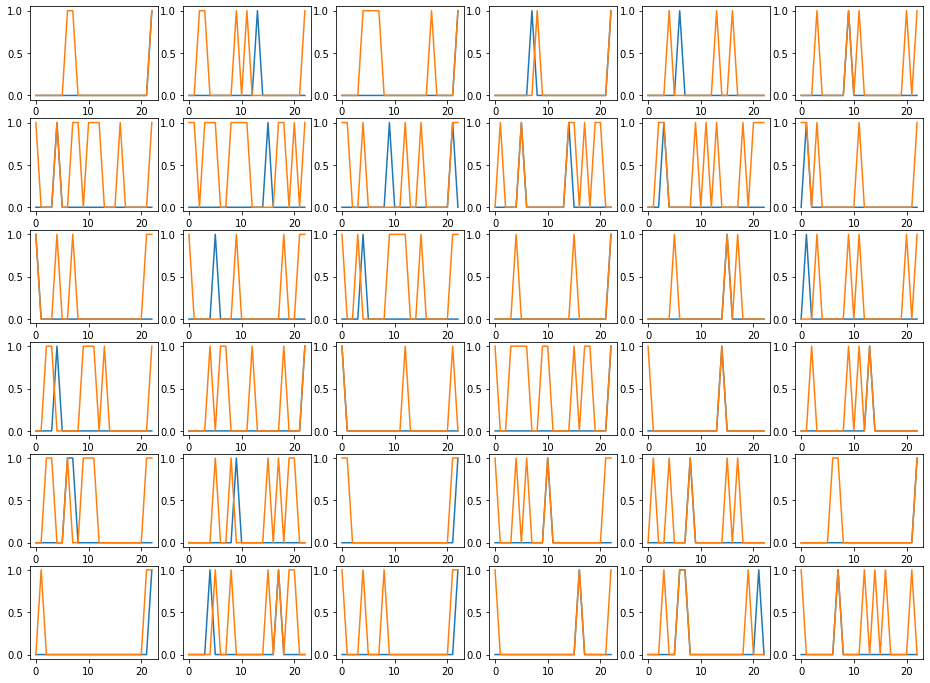

In [ ]:
#np.set_printoptions(precision=4)
#print(str(test_df['Labels'][0]), "\n", str(test_df['Predictions'][0]))

#print(f'{test_df['Predictions'][0]:.5f})
j = 0
fig,ax = plt.subplots(6,6)
fig.set_size_inches(16,12)
#i = 57

for i in range(len(test_df['Labels'])):
      if j<36:
        # print out the incorrect images to evaluate whether there
        # is a human-detectable reason why the classification failed
        #ax[j].title.set_text('Actual %d\nPredicted %d' % \
        #                     (Y_test[i].argmax(), predictions[i].argmax()))
        #ax[j].imshow(instance)
        ax[i%6,i//6].plot(test_df['Labels'][i])
        ax[i%6,i//6].plot(test_df['Predictions'][i])
        j += 1

#plt.plot(test_df['Labels'][i])
#plt.plot(test_df['Predictions'][i])

In [ ]:
mlcm = metric5.result().numpy()
mlcm.shape

(23, 2, 2)

IndexError: ignored

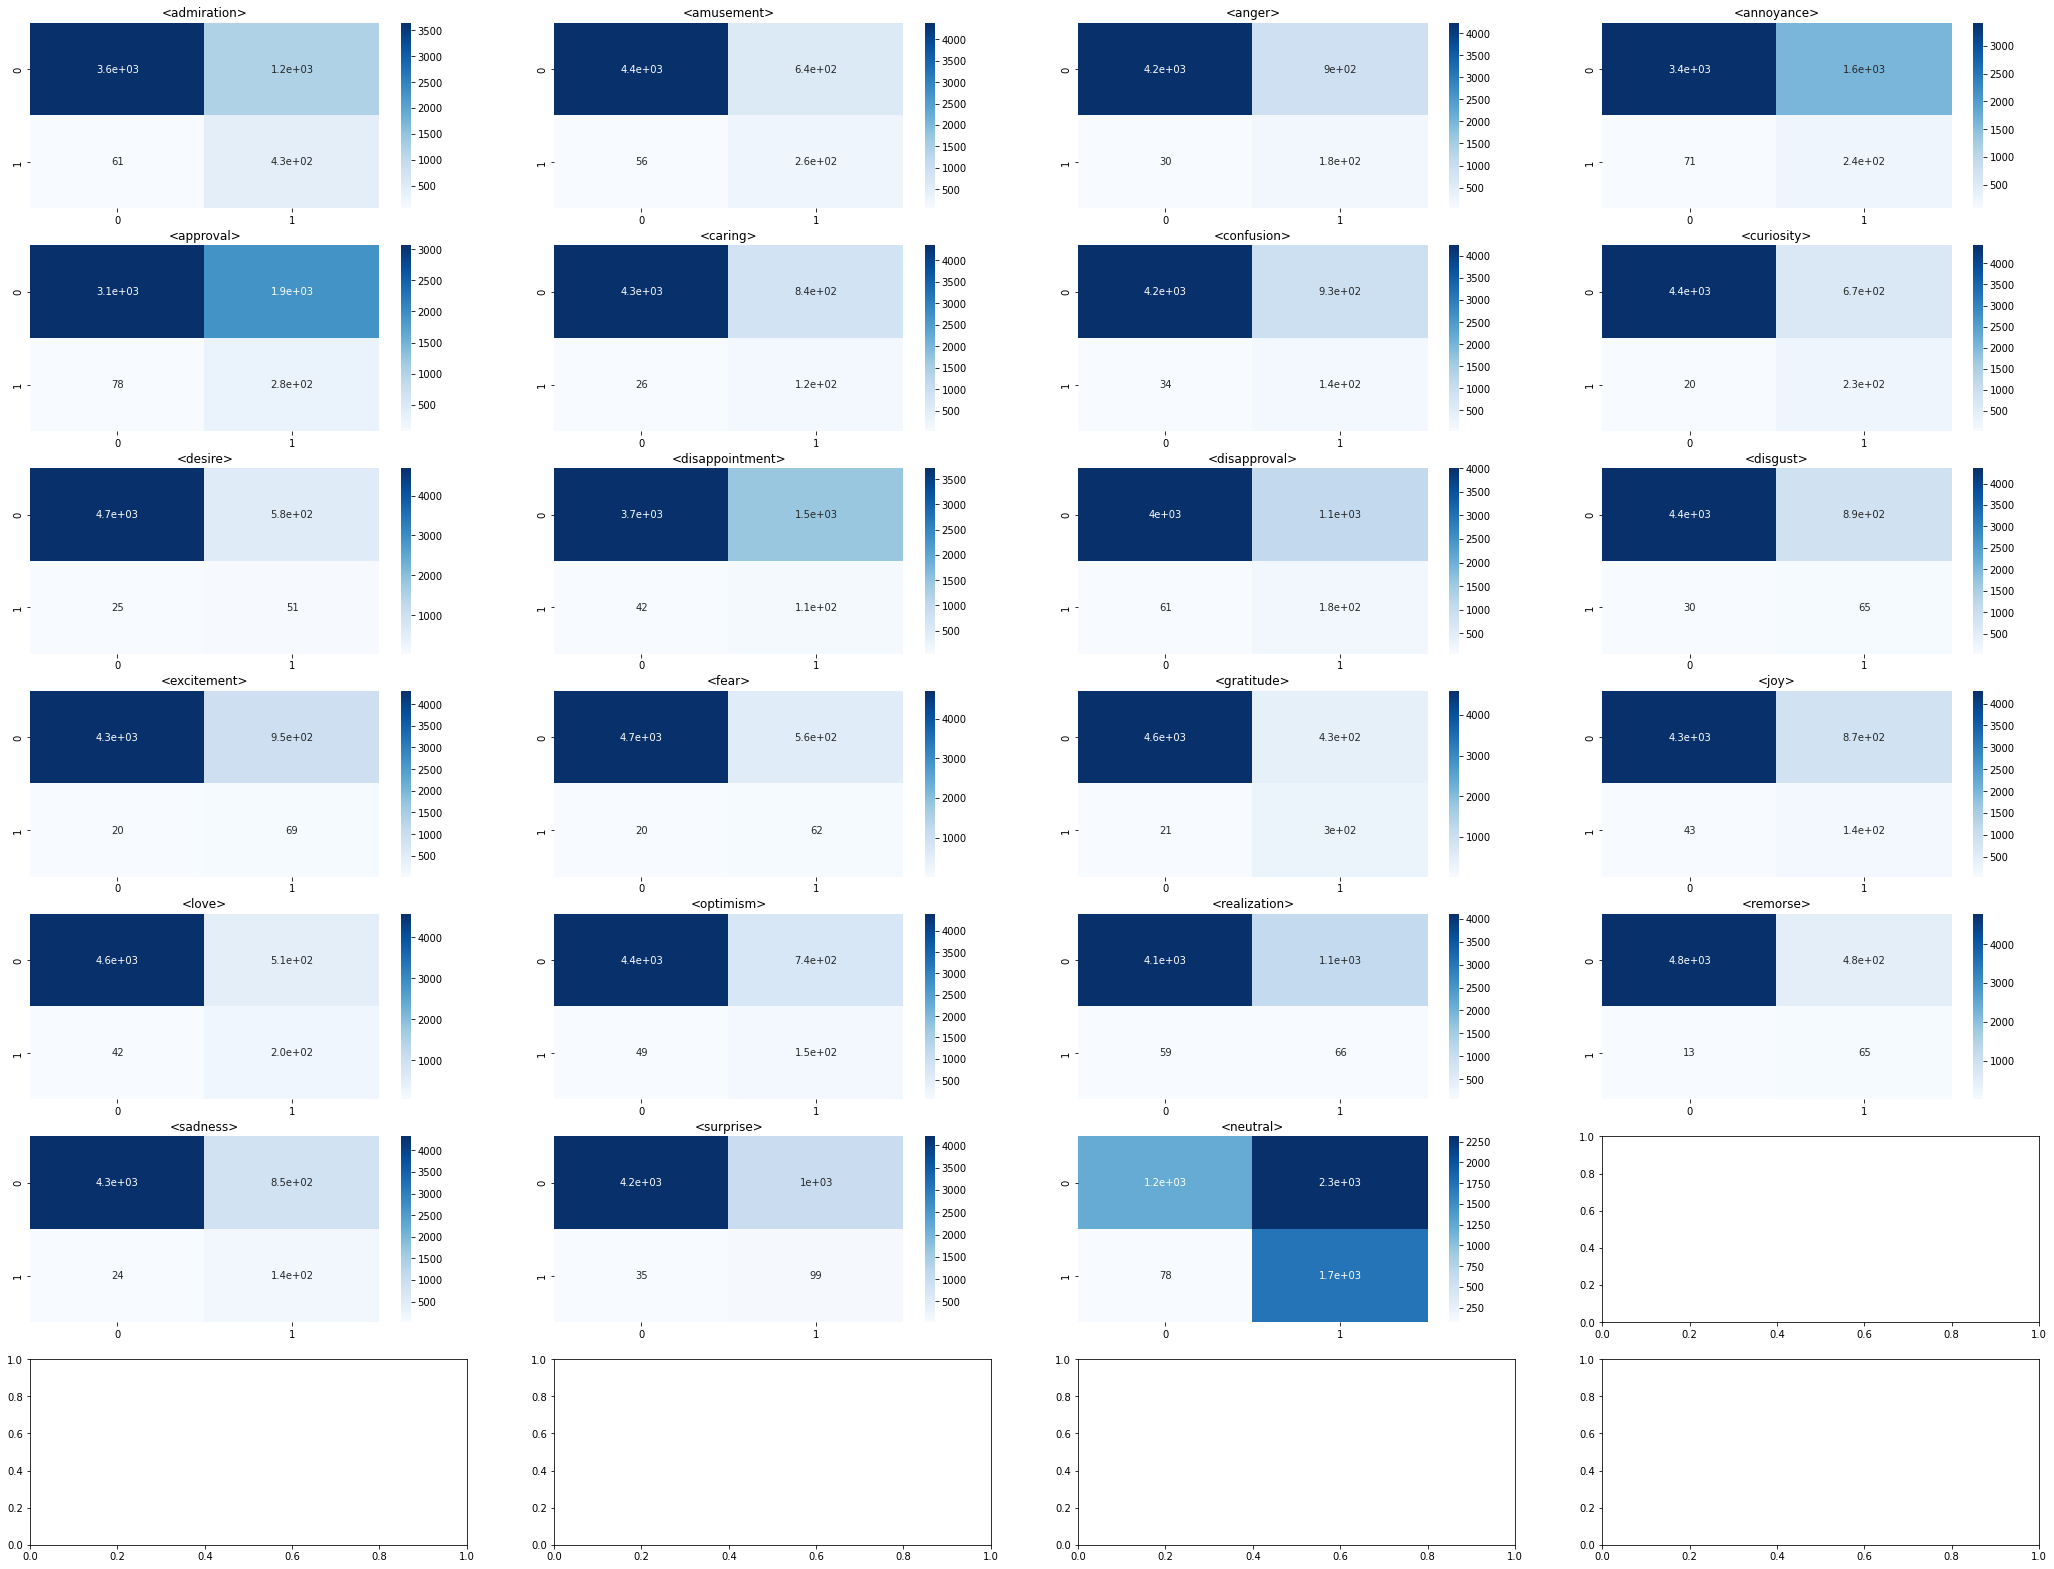

In [ ]:
import seaborn as sns

#fig,ax = plt.subplots(1,3)

fig, axes = plt.subplots(ncols=4, nrows=7)
fig.set_size_inches(36,28)

for i, ax in zip(range(df_clean.shape[1]), axes.flat):
  ax.set_title('<{}>'.format(df_clean.columns[i+1]));
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values ');

  ax.xaxis.set_ticklabels(['False','True'])
  ax.yaxis.set_ticklabels(['False','True'])
    
  sns.heatmap(mlcm[i,:,:], annot=True, cmap='Blues', ax=ax)
plt.show()

In [ ]:
df_clean.sum(axis=0)

In [ ]:
y_train.sum(axis=0)

In [ ]:
y_val.sum(axis=0)

In [ ]:
y_test.sum(axis=0)

# Simple Transformers -- for Baseline Purposes Only

In [ ]:
!pip install simpletransformers

In [ ]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs

# Optional model configuration
model_args = ClassificationArgs(num_train_epochs=2, train_batch_size=224, max_seq_length=256)

# Create a ClassificationModel
simple_model = ClassificationModel("roberta", "distilroberta-base", args=model_args)

In [ ]:
# Train the model
simple_df = y_train.copy()

#print(y_train.to_numpy()[0])
#simple_df['Label'] = pd.Series(y_train.values)
simple_df.insert(0, 'labels', y_train.values.tolist())
#simple_df.insert(0, 'Label', y_train.values)
simple_df.insert(0, 'text', df_X_train['text'])
#simple_df['Label'] = y_train
#simple_df.head()
simple_model.train_model(simple_df, multi_label=True, )


#model.evaluate(x = [inputs_and_masks["inputs"], 
#                        inputs_and_masks["masks"]],
#                        y = label, verbose=2)

#test_loss, test_metrics = eval_model(model, test_model_inputs_and_masks, np_array_y_test)